In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as linalg
import cv2
import matplotlib.pyplot as mpplt
%matplotlib inline

In [27]:
def load_image(source,mask,target, DATA_ROOT):



  print(DATA_ROOT+"source/"+"source_"+filename)
  image_data = {}
  #source = cv2.imread('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Blend_testing/source/test.png') # source
 # mask = cv2.imread('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Blend_testing/mask/test.png') # mask
  #target = cv2.imread('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Blend_testing/target/test.png') # target

  #resize source and mask to target size
  source = cv2.resize(source, (target.shape[1], target.shape[0]))
  mask = cv2.resize(mask, (target.shape[1], target.shape[0]))

  # normalize the images
  image_data['source'] = cv2.normalize(source.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
  image_data['mask'] = cv2.normalize(mask.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
  image_data['target'] = cv2.normalize(target.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
  image_data['dims'] = (-1,-1)#target.shape[:2] #target_offsets[int(filename[:-4])-1]
  
  return image_data

def display_image(image_data):
  # show the image
  mpplt.figure(figsize=(16,16))
  for i in range(3):
    if(i == 0):
      img_string = 'source'
    elif(i == 1):
      img_string = 'mask'
    else:
      img_string = 'target'
    img = image_data[img_string]
    mpplt.subplot(1,3,i+1)
    mpplt.imshow(img[:,:,[2,1,0]])
    

In [3]:
def preprocess(image_data):
  # extract image data
  source = image_data['source']
  mask = image_data['mask']
  target = image_data['target']
  
  # get image shape and offset
  Hs,Ws,_ = source.shape
  Ht,Wt,_ = target.shape
  Ho, Wo = image_data['dims']
  
  # adjust source and mask if offset is negative.
  # if mask is rolled eg. from the top it rolls 
  # to the bottom, crop the rolled portion
  if(Ho < 0):
    mask = np.roll(mask, Ho, axis=0)
    source = np.roll(source, Ho, axis=0)
    mask[Hs+Ho:,:,:] = 0 # added because Ho < 0
    source[Hs+Ho:,:,:] = 0
    Ho = 0
  if(Wo < 0):
    mask = np.roll(mask, Wo, axis=1)
    source = np.roll(source, Wo, axis=1)
    mask[:,Ws+Wo:,:] = 0
    source[:,Ws+Wo:,:] = 0
    Wo = 0
  
  # mask region on target
  H_min = Ho
  H_max = min(Ho + Hs, Ht)
  W_min = Wo
  W_max = min(Wo + Ws, Wt)
  
  # crop source and mask if they lie outside the bounds of the target
  source = source[0:min(Hs, Ht-Ho),0:min(Ws, Wt-Wo),:]
  mask = mask[0:min(Hs, Ht-Ho),0:min(Ws, Wt-Wo),:]
  
  return {'source':source, 'mask': mask, 'target': target, 'dims':[H_min,H_max,W_min,W_max]}
  

In [4]:
# performs naive cut-paste from source to target
def naive_copy(image_data):
  # extract image data
  source = image_data['source']
  mask = image_data['mask']
  target = image_data['target']
  dims = image_data['dims']
  
  target[dims[0]:dims[1],dims[2]:dims[3],:] = target[dims[0]:dims[1],dims[2]:dims[3],:] * (1 - mask) + source * mask
  
  return target
  

In [5]:
def get_subimg(image, dims):
   return image[dims[0]:dims[1], dims[2]:dims[3]]

def poisson_blending(image, GRAD_MIX):
  # comparison function
  def _compare(val1, val2):
    if(abs(val1) > abs(val2)):
      return val1
    else:
      return val2
  
  # membrane (region where Poisson blending is performed)
  mask = image['mask']
  Hs,Ws = mask.shape
  num_pxls = Hs * Ws
  
  # source and target image
  source = image['source'].flatten(order='C')
  target_subimg = get_subimg(image['target'], image['dims']).flatten(order='C')

  # initialise the mask, guidance vector field and laplacian
  mask = mask.flatten(order='C')
  guidance_field = np.empty_like(mask)
  laplacian = sps.lil_matrix((num_pxls, num_pxls), dtype='float64')

  for i in range(num_pxls):
    # construct the sparse laplacian block matrix
    # and guidance field for the membrane
    if(mask[i] > 0.99):
      
      laplacian[i, i] = 4
      
      # construct laplacian, and compute source and target gradient in mask
      if(i - Ws > 0):
        laplacian[i, i-Ws] = -1
        Np_up_s = source[i] - source[i-Ws]
        Np_up_t = target_subimg[i] - target_subimg[i-Ws]
      else:
        Np_up_s = source[i]
        Np_up_t = target_subimg[i]
        
      if(i % Ws != 0):
        laplacian[i, i-1] = -1
        Np_left_s = source[i] - source[i-1]
        Np_left_t = target_subimg[i] - target_subimg[i-1]
      else:
        Np_left_s = source[i]
        Np_left_t = target_subimg[i]
        
      if(i + Ws < num_pxls):
        laplacian[i, i+Ws] = -1
        Np_down_s = source[i] - source[i+Ws]
        Np_down_t = target_subimg[i] - target_subimg[i+Ws]
      else:
        Np_down_s = source[i]
        Np_down_t = target_subimg[i]
        
      if(i % Ws != Ws-1):
        laplacian[i, i+1] = -1
        Np_right_s = source[i] - source[i+1]
        Np_right_t = target_subimg[i] - target_subimg[i+1]
      else:
        Np_right_s = source[i]
        Np_right_t = target_subimg[i]
      
      # choose stronger gradient
      if(GRAD_MIX is False):
        Np_up_t = 0
        Np_left_t = 0
        Np_down_t = 0
        Np_right_t = 0
        
      guidance_field[i] = (_compare(Np_up_s, Np_up_t) + _compare(Np_left_s, Np_left_t) + 
                           _compare(Np_down_s, Np_down_t) + _compare(Np_right_s, Np_right_t))

    else:
      # if point lies outside membrane, copy target function
      laplacian[i, i] = 1
      guidance_field[i] = target_subimg[i]
  
  return [laplacian, guidance_field]
  

In [6]:
# linear least squares solver
def linlsq_solver(A, b, dims):
  x = linalg.spsolve(A.tocsc(),b)
  return np.reshape(x,(dims[0],dims[1]))

# stitches poisson equation solution with target
def stitch_images(source, target, dims):
  target[dims[0]:dims[1], dims[2]:dims[3],:] = source
  return target

# performs poisson blending
def blend_image(data, BLEND_TYPE, GRAD_MIX):
  if(BLEND_TYPE == 1):
    image_solution = naive_copy(data)
    
  elif(BLEND_TYPE == 2):
    equation_param = []
    ch_data = {}
    
    # construct poisson equation 
    for ch in range(3):
      ch_data['source'] = data['source'][:,:,ch]
      ch_data['mask'] = data['mask'][:,:,ch]
      ch_data['target'] = data['target'][:,:,ch]
      ch_data['dims'] = data['dims']
      equation_param.append(poisson_blending(ch_data, GRAD_MIX))

    # solve poisson equation
    image_solution = np.empty_like(data['source'])
    for i in range(3):
      image_solution[:,:,i] = linlsq_solver(equation_param[i][0],equation_param[i][1],data['source'].shape)
      
    image_solution = stitch_images(image_solution,image['target'],ch_data['dims'])
    
  else:
    # wrong option
    raise Exception('Wrong option! Available: 1. Naive, 2. Poisson')
      
  return image_solution


/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Blend_testingsource/source_test.png
(-1, -1)


False

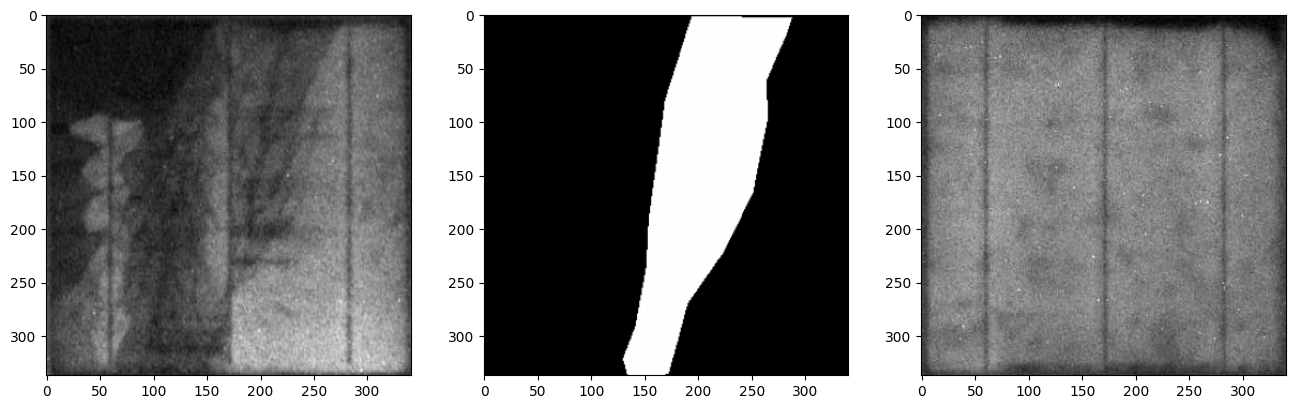

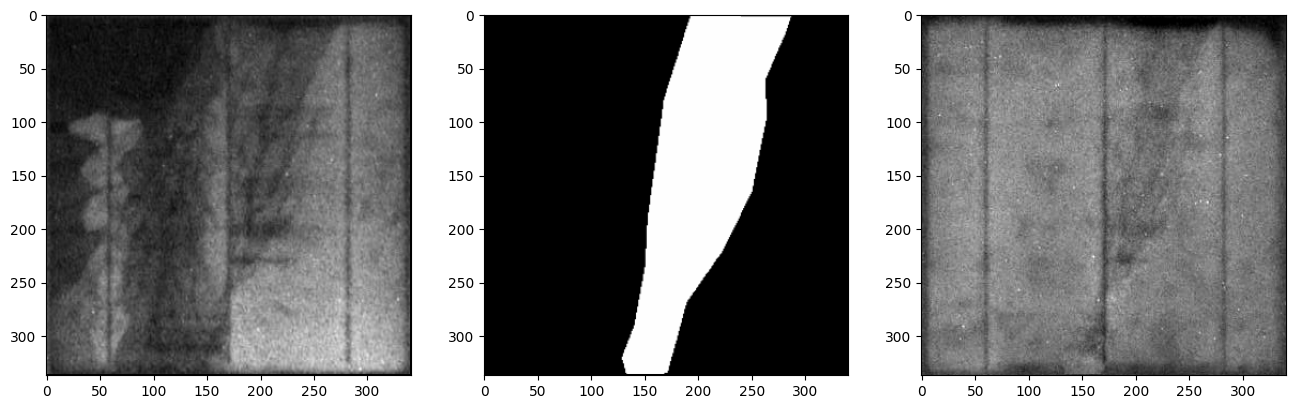

In [30]:
DATA_ROOT = "/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Blend_testing"
target_offsets = [[210, 10], [10, 28], [140, 80], [-40, 90], [60, 100], [20, 20], 
                  [-28, 88], [262,240], [315,629], [568,803], [378,806], [297,195]]
BLEND_TYPE = 2
GRAD_MIX = True
IMAGE_NAME = "test.png"

image = load_image(IMAGE_NAME, DATA_ROOT)
display_image(image) # plot data
print(image['dims'])
data = preprocess(image)
display_image(data) # plot for sanity check
final_image = blend_image(data, BLEND_TYPE, GRAD_MIX) # blend the image

# plot results
final_image = np.clip(final_image,0.0,1.0)
mpplt.subplot(1,3,3)
mpplt.imshow(final_image[:,:,[2,1,0]])

# save image
save_img = final_image * 255
save_img = save_img.astype(np.uint8)
cv2.imwrite(DATA_ROOT+'result/result_'+IMAGE_NAME, save_img, [cv2.IMWRITE_JPEG_QUALITY,90])

In [17]:
target = cv2.imread('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Blend_testing/target/test.png')

In [21]:
target.shape[:2]

(337, 341)

In [24]:
data

{'source': array([], shape=(0, 0, 3), dtype=float64),
 'mask': array([], shape=(0, 0, 3), dtype=float64),
 'target': array([[[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411765],
         [0.14509804, 0.14509804, 0.14509804],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.06666667, 0.06666667, 0.06666667],
         [0.09019608, 0.09019608, 0.09019608]],
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.07843137, 0.07843137, 0.07843137],
         [0.11764706, 0.11764706, 0.11764706],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.07843137, 0.07843137, 0.07843137],
         [0.10196078, 0.10196078, 0.10196078]],
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.06666667, 0.06666667, 0.06666667],
         [0.09411765, 0.09411765, 0.09411765],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.09019608, 0.09019608, 0.09019608],
         [0.11764706, 0.11764706, 0.1